<a href="https://colab.research.google.com/github/Badih-sab/Disease-detection-from-Chest-X-Ray/blob/main/Disease_detection_from_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"memphissb","key":"46c5905982115fc424169b85b392ad3e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                              title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mdsultanulislamovi/student-stress-monitoring-datasets            Student Stress Monitoring Datasets                       24336  2025-07-24 16:30:01.617000          10754        180  1.0              
rohitgrewal/airlines-flights-data                                Airlines Flights Data                                  2440299  2025-07-29 09:16:00.463000          22077        402  1.0              
pratyushpuri/multilingual-mobile-app-reviews-dataset-2025        Multilingual Mobile App Review Dataset August 2025      136331  2025-07-31 03:09:08.217000           3579        139  1.0          

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.21G/2.29G [00:15<00:01, 79.8MB/s]
100% 2.29G/2.29G [00:15<00:00, 156MB/s] 


In [ ]:
import os
#TODO: import tensorflow
import tensorflow as tf


from tensorflow.keras import datasets, layers, models
!pip install matplotlib
#TODO: import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_cxr_data(base_path, target_size=(150,150)):
    images, labels = [], []
    class_names = sorted(os.listdir(base_path))  # ['NORMAL', 'PNEUMONIA']
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file_name)
            img = load_img(img_path, target_size=target_size)
            images.append(img_to_array(img)/255.0)
            labels.append(idx)  # 0=NORMAL, 1=PNEUMONIA
    return np.array(images), np.array(labels)

# Load training and test data
train_images, train_labels = load_cxr_data('chest_xray/train')
test_images, test_labels   = load_cxr_data('chest_xray/test')

print("Train images:", train_images.shape)
print("Test images:", test_images.shape)

Train images: (5216, 150, 150, 3)
Test images: (624, 150, 150, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Data generator with rescaling ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# --- Load images in batches directly ---
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(128,128),  # smaller images → faster
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_images, test_images = train_images / 255.0 , test_images / 255.0

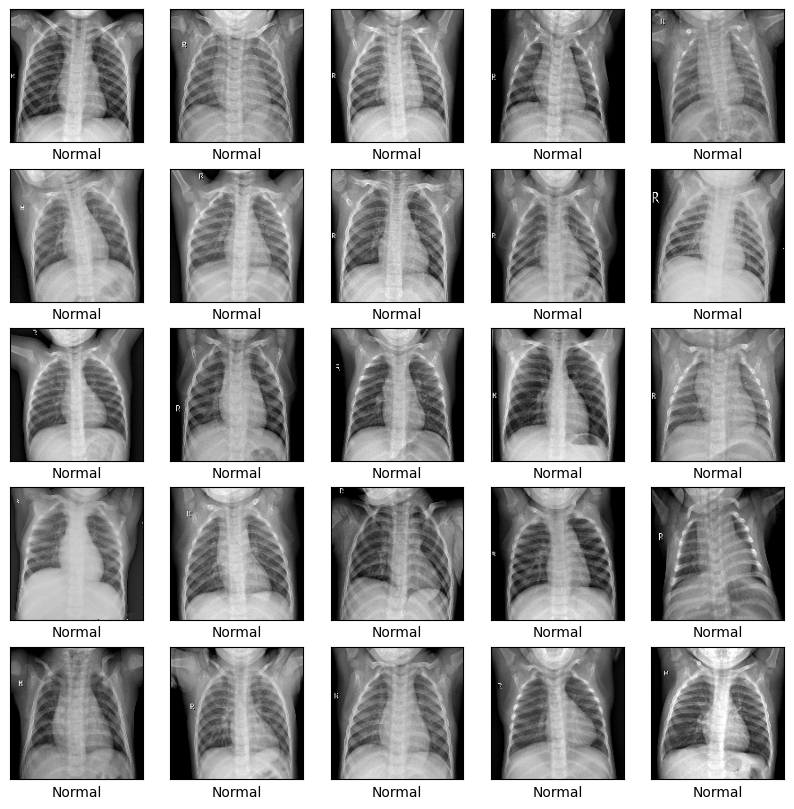

In [ ]:
import matplotlib.pyplot as plt

class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]*255)  # scale for display
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [ ]:
import numpy as np

unique, counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{class_names[label]}: {count} images")

Normal: 1341 images
Pneumonia: 3875 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training (especially for minority class)
train_datagen = ImageDataGenerator(
    rotation_range=20,       # rotate images ±20 degrees
    width_shift_range=0.1,   # shift horizontally
    height_shift_range=0.1,  # shift vertically
    shear_range=0.1,         # tilt the image
    zoom_range=0.1,          # zoom in/out
    horizontal_flip=True,    # flip images
    fill_mode='nearest'      # fill empty pixels after transformation
)

# For testing/validation, no augmentation, just normalization
test_datagen = ImageDataGenerator()

# Example: create augmented batches
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
test_generator  = test_datagen.flow(test_images, test_labels, batch_size=32)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load pre-trained MobileNetV2 without top
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.summary()

/tmp/ipython-input-2991252814.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
x= len(test_labels)
y =len(test_images)
print(x)
print(y)

624
624


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Train model with class weights
history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    class_weight=class_weights_dict
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8057 - loss: 0.4383 - val_accuracy: 0.6939 - val_loss: 0.5602
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7973 - loss: 0.4441 - val_accuracy: 0.6795 - val_loss: 0.6074
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7986 - loss: 0.4535 - val_accuracy: 0.7997 - val_loss: 0.4779
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8613 - loss: 0.3932 - val_accuracy: 0.7949 - val_loss: 0.4885
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8686 - loss: 0.3827 - val_accuracy: 0.7821 - val_loss: 0.4663
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8640 - loss: 0.3831 - val_accuracy: 0.7965 - val_loss: 0.4580
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8528 - loss: 0.3738 - val_accuracy: 0.7083 - val_loss: 0.5073
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8470 - loss: 0.3864 - val_accu

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step
Accuracy: 0.8060897435897436
Precision: 0.7943107221006565
Recall: 0.9307692307692308
F1-score: 0.8571428571428571


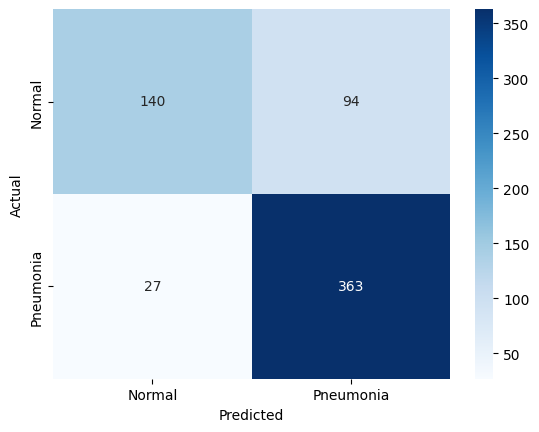

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure labels are 1D
y_true = test_labels.reshape(-1)

# Predict on all test images
y_pred = model.predict(test_images)
# The model output is (None, 1) so we reshape to (None,) and then convert to int
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

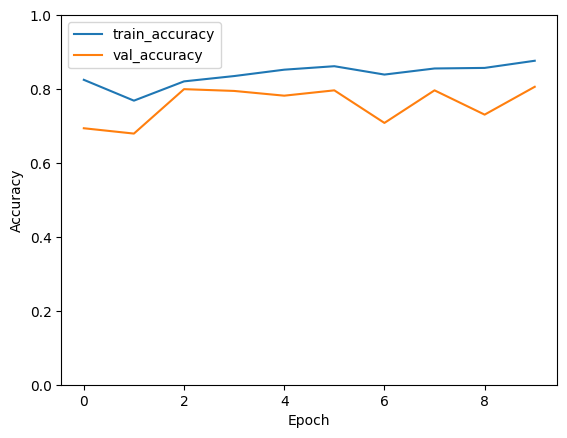

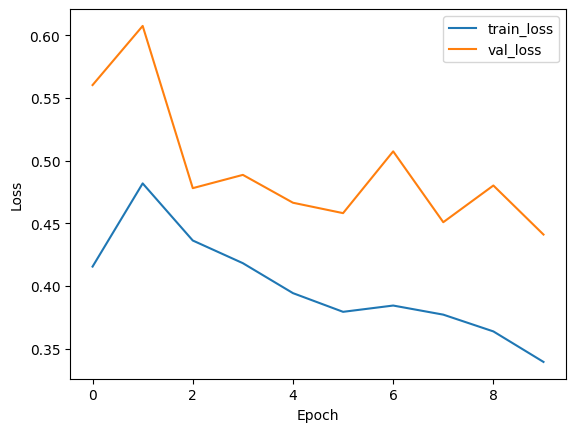

20/20 - 0s - 20ms/step - accuracy: 0.8061 - loss: 0.4409
Test Accuracy: 0.8060897588729858
Test Loss: 0.4409322142601013


In [ ]:

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)
